<a href="https://colab.research.google.com/github/Himaaa-07/SOURCE-CODE-DATA-SET-3-/blob/main/DATASET_3(CARDIO_TRAIN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB
age
36    936
73    909
47    899
53    898
40    897
     ... 
74    794
87    793
75    792
72    776
70    773
Name: count, Length: 83, dtype: int64
################################################################################
gender
1    45530
2

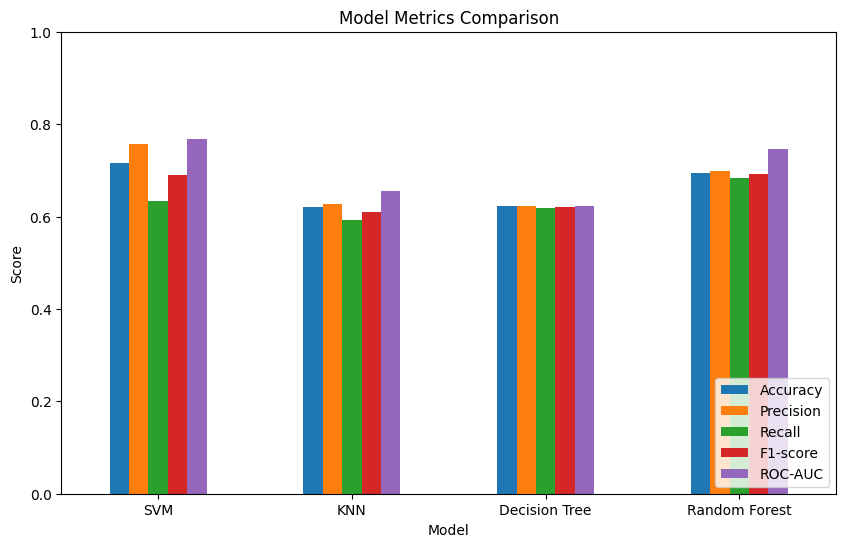

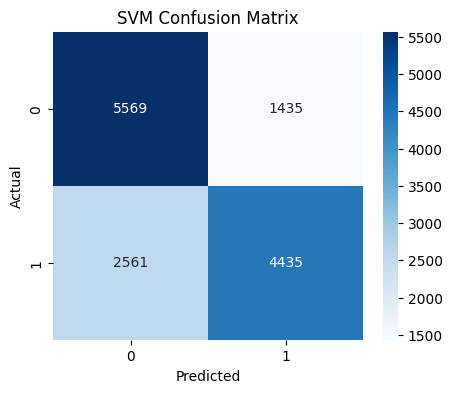

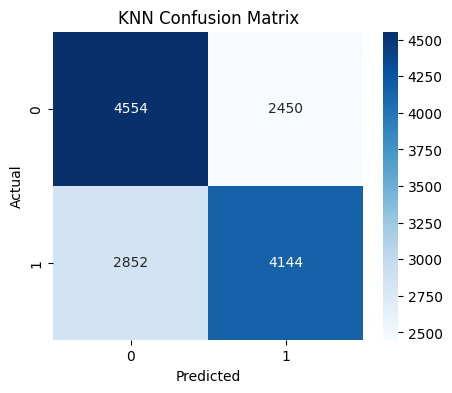

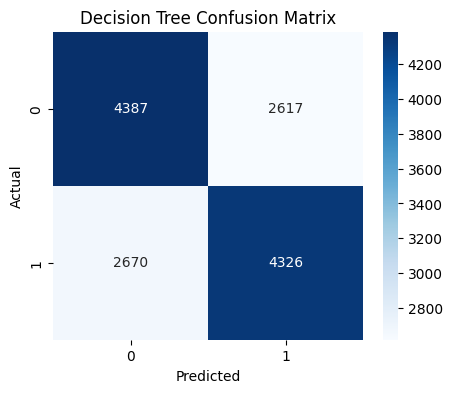

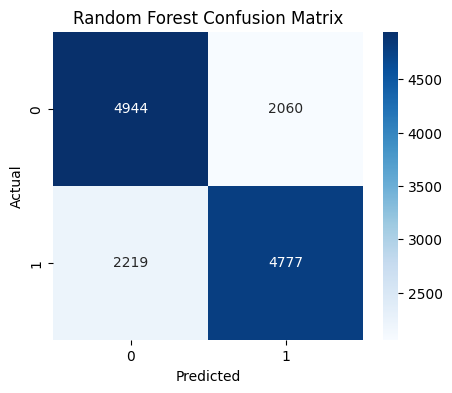

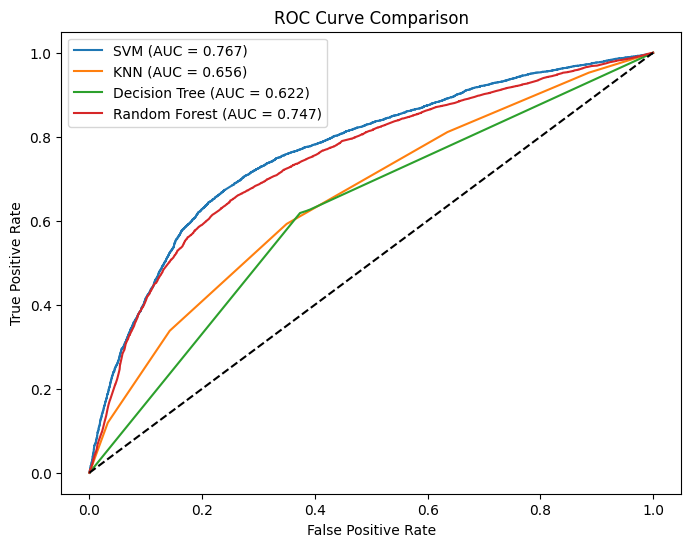

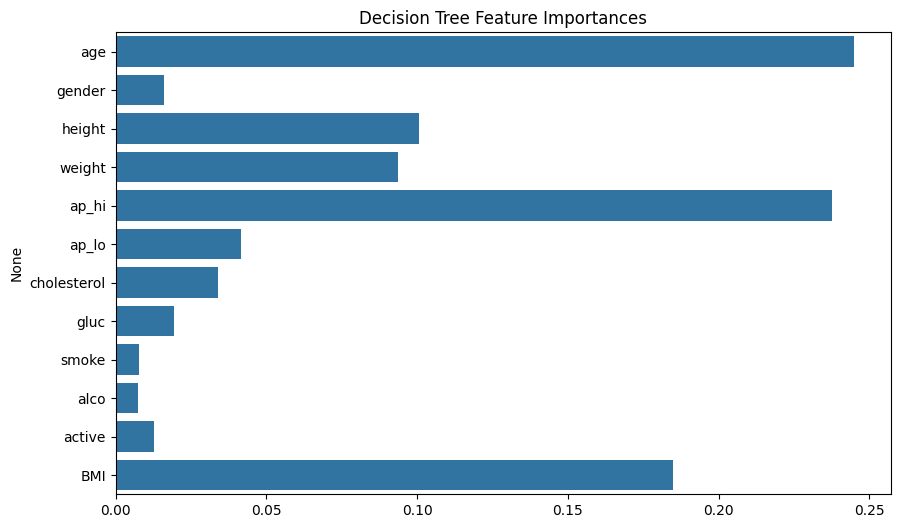

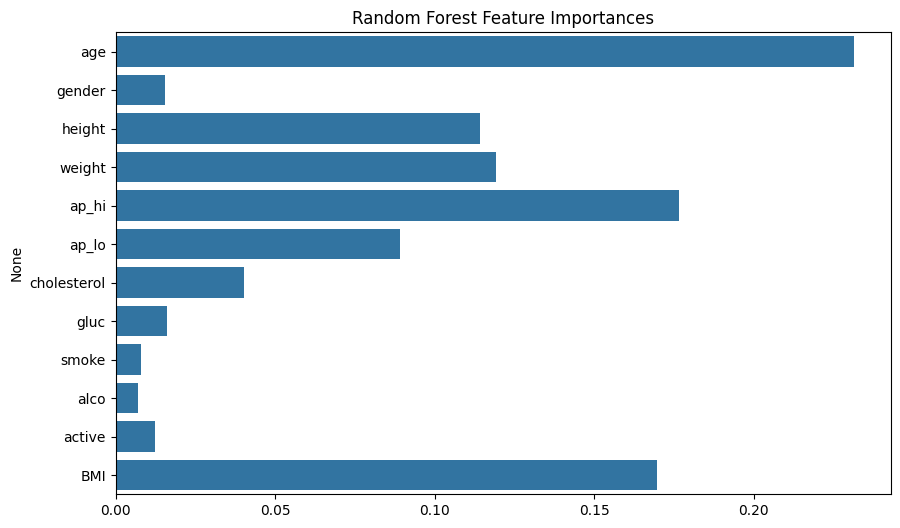

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8d9c8c549254b8bfc7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df=pd.read_csv('/content/cardio_train .csv')
df.head()
df = df.drop(columns=['id'])
df.info()
for i in df.columns:
  print(df[i].value_counts())
  print('#'*80)
df['BMI'] = df['weight'] / ((df['height']/100) ** 2)

X = df.drop('cardio', axis=1)
y = df['cardio']
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
numeric_cols = X.columns.tolist()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=numeric_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=numeric_cols, index=X_test.index)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

models = {
    "SVM": SVC(probability=True, random_state=42),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
}

predictions = {}

for name, model in models.items():
    if name in ["SVM", "KNN"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:,1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:,1]
    predictions[name] = {"y_pred": y_pred, "y_proba": y_proba, "model": model}
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

metrics_list = []

for name, result in predictions.items():
    y_pred = result["y_pred"]
    y_proba = result["y_proba"]

    metrics_list.append({
        "Model": name,
        "Accuracy": round(accuracy_score(y_test, y_pred),3),
        "Precision": round(precision_score(y_test, y_pred),3),
        "Recall": round(recall_score(y_test, y_pred),3),
        "F1-score": round(f1_score(y_test, y_pred),3),
        "ROC-AUC": round(roc_auc_score(y_test, y_proba),3)
    })

metrics_df = pd.DataFrame(metrics_list).set_index("Model")
print(metrics_df)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

metrics_df.plot(kind='bar', figsize=(10,6), ylim=(0,1))
plt.title("Model Metrics Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

for name, result in predictions.items():
    cm = confusion_matrix(y_test, result["y_pred"])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plt.figure(figsize=(8,6))
for name, result in predictions.items():
    fpr, tpr, _ = roc_curve(y_test, result["y_proba"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()
features = X.columns

dt_model = predictions["Decision Tree"]["model"]
plt.figure(figsize=(10,6))
sns.barplot(x=dt_model.feature_importances_, y=features)
plt.title("Decision Tree Feature Importances")
plt.show()

rf_model = predictions["Random Forest"]["model"]
plt.figure(figsize=(10,6))
sns.barplot(x=rf_model.feature_importances_, y=features)
plt.title("Random Forest Feature Importances")
plt.show()

import gradio as gr
import numpy as np

best_model_name = metrics_df["Accuracy"].idxmax()
best_model = predictions[best_model_name]["model"]

numeric_cols = X.columns.tolist()

def predict_cvd(age, gender, height, weight, ap_hi, ap_lo, cholesterol,
                gluc, smoke, alco, active):


    BMI = weight / ((height/100)**2)


    input_data = np.array([[age, gender, height, weight, ap_hi, ap_lo,
                            cholesterol, gluc, smoke, alco, active, BMI]])


    scaled_data = scaler.transform(input_data)


    prediction = best_model.predict(scaled_data)[0]
    probability = best_model.predict_proba(scaled_data)[0][1]

    if prediction == 1:
        result = f" The person is predicted to HAVE cardiovascular disease.\n Risk probability: {probability:.3f}"
    else:
        result = f" The person is predicted to NOT have cardiovascular disease.\n Risk probability: {probability:.3f}"

    return result

interface = gr.Interface(
    fn=predict_cvd,
    inputs=[
        gr.Number(label="Age", value=55),
        gr.Radio([1, 2], label="Gender (1=Male, 2=Female)", value=1),
        gr.Number(label="Height (cm)", value=170),
        gr.Number(label="Weight (kg)", value=70),
        gr.Number(label="Systolic Blood Pressure (ap_hi)", value=140),
        gr.Number(label="Diastolic Blood Pressure (ap_lo)", value=90),
        gr.Slider(1, 3, step=1, label="Cholesterol (1=normal, 2=above normal, 3=well above normal)", value=1),
        gr.Slider(1, 3, step=1, label="Glucose (1=normal, 2=above normal, 3=well above normal)", value=1),
        gr.Radio([0, 1], label="Smoke (0=No, 1=Yes)", value=0),
        gr.Radio([0, 1], label="Alcohol Intake (0=No, 1=Yes)", value=0),
        gr.Radio([0, 1], label="Physical Activity (0=No, 1=Yes)", value=1)
    ],
    outputs="text",
    title=" Cardiovascular Disease Prediction App",
    description="Enter patient details to predict whether the person has cardiovascular disease.",
    theme="soft"
)

interface.launch()
